In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 144

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from pylib.draw_nn import draw_neural_net_fig

In [3]:
sess = None

def reset_vars():
    sess.run(tf.global_variables_initializer())

def reset_tf():
    global sess
    if sess:
        sess.close()
    tf.reset_default_graph()
    sess = tf.Session()

<!-- requirement: pylib/__init__.py -->
<!-- requirement: pylib/draw_nn.py -->
<!-- requirement: images/neuron.svg -->

# Basic Neural Networks

The operation of a logistic regression model is not so dissimilar from a neuron.  A neuron has many dendrites, each of which gets some input.  These inputs are individually weighted and all of the inputs are summed by the soma.  Depending on the result, the neuron may send a signal out its axon, to trigger other neurons.

![neuron](images/neuron.svg)
<!-- Copyright Quasar Jarosz.  Distributed under the CC Attribution-Share Alike 3.0 Unported Licence.  https://commons.wikimedia.org/wiki/File:Neuron_Hand-tuned.svg -->

Similarly, a logistic regression takes many inputs, weights each, and combines them into a single output.  We can think of this model as an **artificial neuron**.

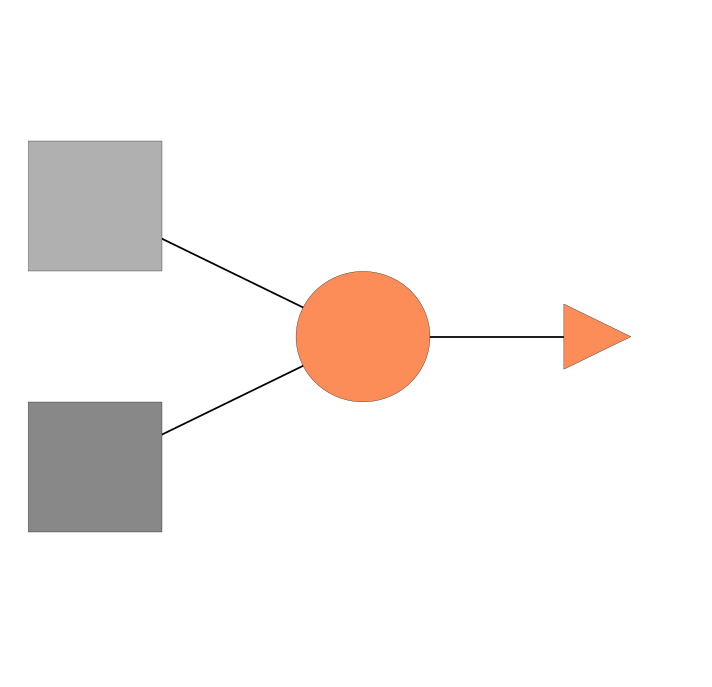

In [4]:
draw_neural_net_fig([2, 1])

This analogy should not be taken too seriously&mdash;real neurons fire a discrete pulse every time the potential in the soma exceeds a threshold, while our model outputs a continuous value depending on the current value of all its inputs.  Nonetheless, there is enough similarity to think that wiring together artificial neurons could improve their performance, in the same way that an entire brain performs better than a single neuron.

## The XOR problem

Research into artificial neurons dates to the late 40s, but it was not until 1969 that Martin Minsky and Seymour Papert pointed out that basic neurons were unable to reproduce the **exclusive-or** (XOR) function.  This boolean function of two boolean variables returns true if exactly one of its inputs is true:

$$ \mathrm{XOR}(0, 0) = \mathrm{XOR}(1, 1) = 0 \ \ \ \ \ \ \mathrm{XOR}(0, 1) = \mathrm{XOR}(1, 0) = 1 $$

Below, we create a related two-class classification problem, with one class clustered about (0, 0) and (1, 1), and the other about (0, 1) and (1, 0).  It would be quite easy to draw a boundary separating the two classes by hand.

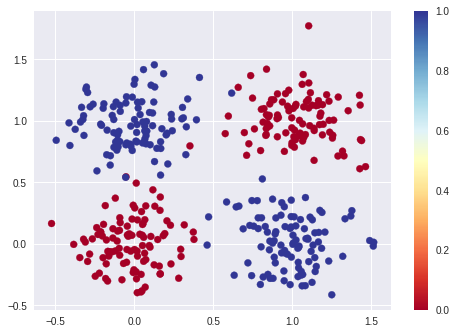

In [5]:
centers = np.array([[0, 0]] * 100 + [[1, 1]] * 100
                   + [[0, 1]] * 100 + [[1, 0]] * 100)
np.random.seed(42)
data = np.random.normal(0, 0.2, (400, 2)) + centers
labels = np.array([[0]] * 200 + [[1]] * 200)

plt.scatter(data[:,0], data[:,1], c=labels, cmap=plt.cm.RdYlBu)
plt.colorbar();

Below, we build a simple logistic classifier for these data.  It takes two features of input and returns a prediction for the probability of being in class 1.

In [6]:
reset_tf()

x = tf.placeholder(tf.float32, [None, 2], name="features")
y_label = tf.placeholder(tf.float32, [None, 1], name="labels")

W = tf.Variable(tf.zeros([2, 1]), name="weights")
b = tf.Variable(tf.zeros([1]), name="biases")
y = tf.matmul(x, W) + b

loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y, 
                                                              labels=y_label))
train = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

predicted = tf.cast(tf.nn.sigmoid(y) > 0.5, np.float32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, y_label), np.float32))

Let's train it for a little.  (We might get slightly better performance with minibatching, but there's little enough data that the full batch performs okay.)

In [7]:
reset_vars()

for i in range(300):
    sess.run(train, feed_dict={x: data, y_label: labels})
    if i % 30 == 0:
        print sess.run([loss, accuracy],
                       feed_dict={x: data, y_label: labels})

[0.69313836, 0.36250001]
[0.69304931, 0.40000001]
[0.69302946, 0.465]
[0.69302469, 0.5]
[0.6930235, 0.51749998]
[0.6930232, 0.51999998]
[0.69302309, 0.52249998]
[0.69302309, 0.52499998]
[0.6930232, 0.52499998]
[0.69302309, 0.52499998]


That's a bit odd.  The model seems to get stuck on 52% accuracy.  More notably, the entropy has barely improved at all.

Let's visualize the predictions.  Note that the color scale only covers a portion of the range.

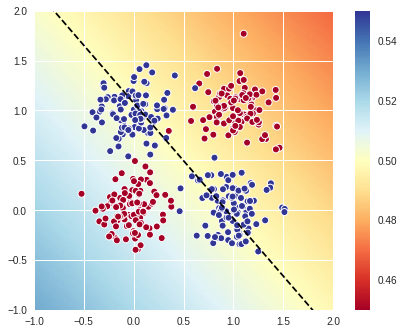

In [8]:
mesh = np.column_stack(a.reshape(-1) for a in np.meshgrid(np.r_[-1:2:100j], np.r_[-1:2:100j]))
ymesh = sess.run(tf.nn.sigmoid(y), feed_dict={x: mesh})
ww, bb = sess.run([W, b])

plt.imshow(ymesh.reshape(100,100), cmap=plt.cm.RdYlBu, origin='lower',
           extent=(-1, 2, -1, 2), vmin=0.45, vmax=0.55)
plt.colorbar()
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap=plt.cm.RdYlBu,
            edgecolor='w', lw=1)
xx = np.linspace(-1, 2, 100)
yy = -ww[0] / ww[1] * xx - bb / ww[1]
plt.plot(xx, yy, 'k--')
plt.axis((-1, 2, -1, 2));

Now the problem becomes apparent: The model is returning nearly a 50% probability for each observation.  Therefore the entropy is stuck at just about $-\log\frac12 \approx 0.6931$.

We can draw a line at $p = 0.5$ to separate the two classes.  From the logistic function, we know this is equivalent to $x\cdot W + b = 0$.  Thus, our model is attempting to draw a straight line through the plane to separate the two classes.  (In the general case, logistic regression separates the classes with a $(n-1)$-D hyperplane in $n$-D space.)  No line can do that in this case, so the model falls back to guessing 50% for each.

We might wonder why the line wasn't chosen to separate one cluster from the other three.  This could have given us an accuracy approaching 0.75.  But remember that we are optimizing entropy, which is based on the probability estimates, not accuracy.  Because the probability grows the further we go from the threshold line, the penalty for the one cluster on the wrong side of the line would outweigh the gains from the two clusters put fully on the right side.

## Hidden layers

Let's try to combine these artificial neurons into a more complex configuration.  We'll make a network with a single **hidden layer** of size two.  That is, we will have two logistic regressions whose outputs are not visible.  Instead, they are fed into a third, visible neuron, whose output we use.

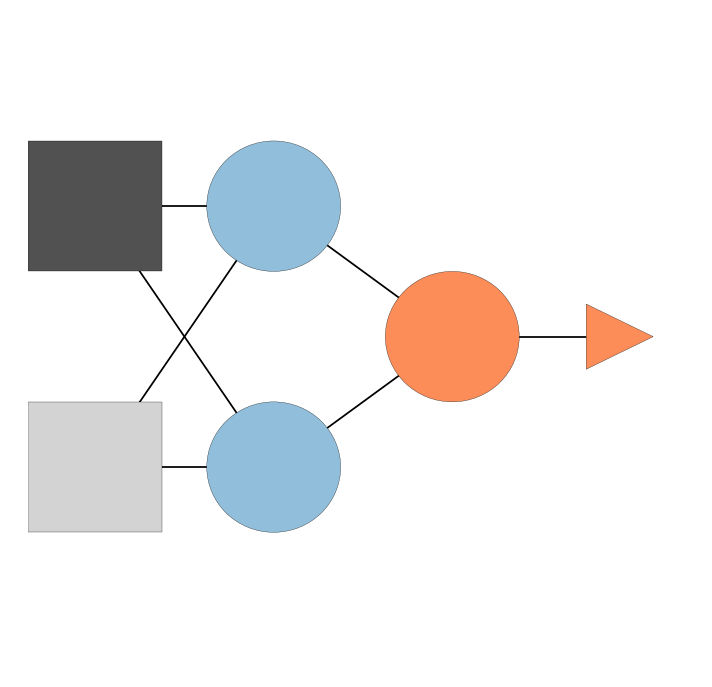

In [9]:
draw_neural_net_fig([2, 2, 1])

The math behind this isn't as bad as it might seem at first.  All of the weights of the neurons in the hidden layer can be combined into a single $2\times2$ matrix $W^{(1)}$.  The final neuron's weights will be in a $2\times1$ matrix $W^{(2)}$.  The biases behave similarly.  Then our final probabilistic prediction is just

$$ p_j = f_2\bigg( f_1\left( X_{ji} W^{(1)}_{ik} + b^{(1)}_k \right) W^{(2)}_k + b^{(2)} \bigg)$$

We are using the Einstein notation: All repeated indices are implicitly summed over.  Both $f_1$ and $f_2$ represent the logistic function, which is taken to operate element-wise over tensors.

The **backpropagation** algorithm, developed by Paul Werbos in 1975, points out that we can use gradient descent (or similar algorithms) to optimize all of the parameters in these sorts of expressions.  All it takes is successive applications of the chain rule.  In fact, there's nothing special we have to do to make use of it: TensorFlow's optimizers automatically work though the successive derivatives to generate the update rules.  All we have to do is set up the calculation:

In [44]:
hidden_size = 8
W1 = tf.Variable(tf.random_normal([2, hidden_size], seed=42), name="weight1")
b1 = tf.Variable(tf.zeros([hidden_size]), name="bias1")

#hidden = tf.nn.sigmoid(tf.matmul(x, W1) + b1, name="hidden")
#hidden = tf.nn.relu(tf.matmul(x,W1)+b1, name="hidden")
hidden = tf.nn.relu_layer(x,W1,b1)

W2 = tf.Variable(tf.random_normal([hidden_size, 1], seed=24), name="weight2")
b2 = tf.Variable(tf.zeros([1]), name="bias2")

y = tf.matmul(hidden, W2) + b2

loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y,labels=y_label))
train = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

predicted = tf.cast(tf.nn.sigmoid(y) > 0.5, np.float32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, y_label), np.float32))

And let's run it.  We need a few more steps to get all of the weights well-trained.

In [45]:
reset_vars()

for i in range(3000):
    sess.run(train, feed_dict={x: data, y_label: labels})
    if i % 300 == 0:
        print sess.run([loss, accuracy],
                       feed_dict={x: data, y_label: labels})

[0.83419782, 0.60500002]
[0.12638597, 0.95249999]
[0.11984715, 0.94999999]
[0.1169368, 0.94999999]
[0.088244908, 0.96749997]
[0.051230621, 0.98500001]
[0.037151352, 0.99000001]
[0.03092433, 0.99250001]
[0.027403655, 0.99250001]
[0.025133619, 0.99250001]


We can verify the improved accuracy by examining our predictions.

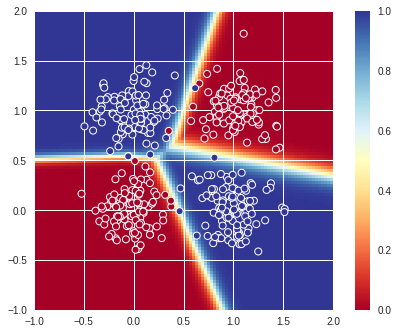

In [46]:
mesh = np.column_stack(a.reshape(-1) for a in np.meshgrid(np.r_[-1:2:100j], np.r_[-1:2:100j]))
ymesh = sess.run(tf.nn.sigmoid(y), feed_dict={x: mesh})

plt.imshow(ymesh.reshape(100,100), cmap=plt.cm.RdYlBu, origin='lower',
           extent=(-1, 2, -1, 2), vmin=0, vmax=1)
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap=plt.cm.RdYlBu,
            edgecolor='w', lw=1)
plt.axis((-1, 2, -1, 2))
plt.colorbar();

How is that stripe created?  We can get some understanding by looking at the weights of the hidden layer.

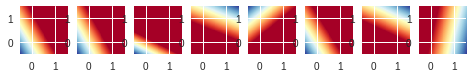

In [47]:
ww1 = sess.run(W1)
hmesh = sess.run(hidden, feed_dict={x: mesh})

for i in xrange(hidden_size):
    plt.subplot(1, hidden_size, i+1)
    plt.imshow(hmesh[:, i].reshape((100, 100)), origin='lower', cmap=plt.cm.RdYlBu,
               extent=(-0.5,1.5,-0.5,1.5))

Now we can see how each hidden neuron is just defining a line through the feature space.  Each line defines one side of the strip.

Note that the colors are inverted from the final probabilities.  We can understand what's going on by examining the weights in the second layer:

In [48]:
sess.run(W2)

array([[-4.5791955 ],
       [-2.11953783],
       [ 0.13570537],
       [-2.43633342],
       [ 5.9522562 ],
       [-0.98656362],
       [-3.27661109],
       [ 1.95180964]], dtype=float32)

## Excercise: Number of hidden neurons

Change the number of neurons in the hidden layer.  How does this change the predictions made by the model?  What happens when you add many neurons to this hidden layer?

## Activation functions

How important is the logistic function in the hidden neurons?  We can easily take them out and see what happens.

In [49]:
hidden_size = 2
W1 = tf.Variable(tf.random_normal([2, hidden_size]), name="weight1")
b1 = tf.Variable(tf.random_normal([hidden_size]), name="bias1")

hidden = tf.matmul(x, W1) + b1

W2 = tf.Variable(tf.random_normal([hidden_size, 1]), name="weight2")
b2 = tf.Variable(tf.random_normal([1]), name="bias2")

y = tf.matmul(hidden, W2) + b2

loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y, 
                                                              labels=y_label))
train = tf.train.GradientDescentOptimizer(1e-1).minimize(loss)

predicted = tf.cast(tf.nn.sigmoid(y) > 0.5, np.float32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, y_label), np.float32))

reset_vars()

for i in range(3000):
    sess.run(train,
             feed_dict={x: data, y_label: labels})
    if i % 300 == 0:
        print sess.run([loss, accuracy], 
                       feed_dict={x: data, y_label: labels})

[0.80842012, 0.5]
[0.6939826, 0.41]
[0.69363177, 0.40000001]
[0.69344258, 0.3775]
[0.69332701, 0.35749999]
[0.69324964, 0.32249999]
[0.69319475, 0.28999999]
[0.69315416, 0.5]
[0.6931231, 0.28749999]
[0.69309926, 0.32249999]


That doesn't look good.  It seems that we've fallen back to the single neuron case again.

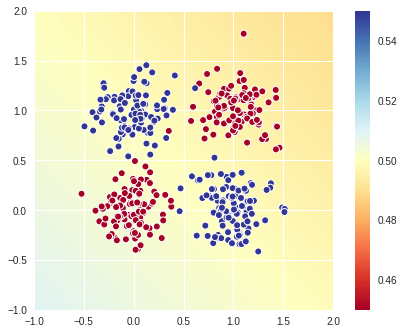

In [50]:
mesh = np.column_stack(a.reshape(-1) for a in np.meshgrid(np.r_[-1:2:100j], np.r_[-1:2:100j]))
ymesh = sess.run(tf.nn.sigmoid(y), feed_dict={x: mesh})

plt.imshow(ymesh.reshape(100,100), cmap=plt.cm.RdYlBu, origin='lower',
           extent=(-1, 2, -1, 2), vmin=0.45, vmax=0.55)
plt.colorbar()
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap=plt.cm.RdYlBu,
            edgecolor='w', lw=1)
plt.axis((-1, 2, -1, 2));

In this behavior becomes obvious when we consider the full neural network function, with $f_1$ being the identity function:

$$ p_j = f_2\bigg( \left( X_{ji} W^{(1)}_{ik} + b^{(1)}_k \right) W^{(2)}_k + b^{(2)} \bigg) = f_2\bigg( X_{ji} \color{red}{W^{(1)}_{ik} W^{(2)}_k} + \color{blue}{b^{(1)}_k W^{(2)}_k + b^{(2)}} \bigg) $$

This is just logistic regression, with the <font color="red">weights</font> and <font color="blue">bias</font> written in a rather funny way.  Given this, it would be odd if we didn't see this behavior!

This function, $f_1$, is known as the **activation function** of the neuron.  As we just saw, the fact that the activation function is nonlinear is crucial.  This is what keeps the whole network from just being a linear transformation.  Any non-linearity will do though, so a number of different activation functions have been proposed.  Here are a few:

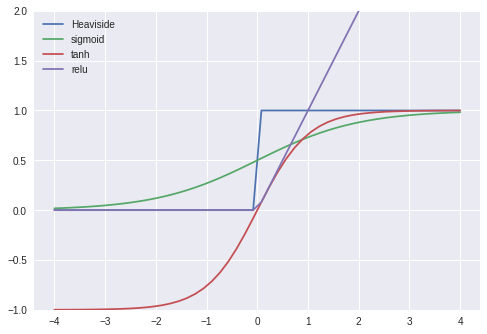

In [51]:
xx = np.linspace(-4, 4)
plt.plot(xx, xx > 0, label='Heaviside')
plt.plot(xx, sess.run(tf.nn.sigmoid(xx)), label='sigmoid')
plt.plot(xx, sess.run(tf.nn.tanh(xx)), label='tanh')
plt.plot(xx, sess.run(tf.nn.relu(xx)), label='relu')
plt.legend(loc=2)
plt.ylim(-1, 2);

The first perceptron, a single-layer neural network, desgined by Frank Rosenblatt in 1957, used the **Heaviside** or **step** function.  This is essentially equivalent to using a threshold with logistic regression.  While this if fine for predicting a class, it has slope 0 almost everywhere, and therefore is unsuitable for use with gradient descent algorithms.

We have already seen the **sigmoid** function used in logistic regression.  In a sense, it smooths out the step function, allowing a usable gradient in the area near $x = 0$.  Because the function saturates at $\pm\infty$, the gradient goes to zero for large positive or negative inputs.  This can cause optimization algorithms to slow down.

The average output of a sigmoid is 0.5, but it performs best when the average input is 0.  Thus, several layers of sigmoid neurons may push themselves away from optimal behavior.  One solution to this is use a **tanh** instead.  While the general shape is the same, its range is [-1, 1], so the output will on average be 0.

The tanh will still have trouble with saturation of the signal.  Recently, many researchers have had success with the **rectified linear unit (ReLU)**: $f(x) = \max(0, x)$.  While it might seem to combine the problems of the other functions (non-analytic points, zero derivatives, non-centered output), in practice it tends to be quite successful.

ReLU neurons are succeptible to dying, however.  If they get into a state where the combined input is negative, both their output value and gradient become zero, and the neurons cease to learn.  Two other activation functions take the linear part of the ReLU and replace the constant zero.  The **leaky ReLU** is also linear for negative inputs, but with a much smaller slope, typically 0.01.  This keeps the benefits of the ReLU, but allows dead neurons to recover eventually.  The **exponential linear unit (ELU)** marries the linear portion to an exponential decay with negative inputs.  This allows the activation function to have a continuous derivative, at the cost of being more expensive to compute.

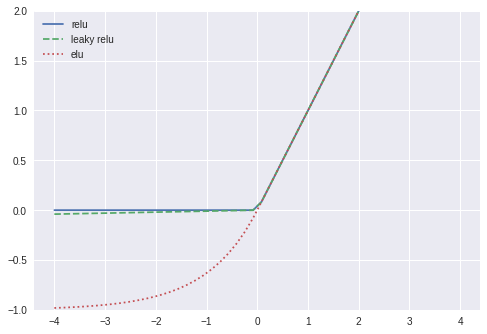

In [52]:
def leaky_relu(x):
    return tf.maximum(0.01 * x, x)

plt.plot(xx, sess.run(tf.nn.relu(xx)), label='relu')
plt.plot(xx, sess.run(leaky_relu(xx)), label='leaky relu', ls='--')
plt.plot(xx, sess.run(tf.nn.elu(xx)), label='elu', ls=':')
plt.legend(loc=2)
plt.ylim(-1, 2);

## Initial weights

Sharp-eyed readers may have already noticed something done differently in the neural networks: the weights are initialized randomly, instead of being set to zero.  This breaks the symmetry of the two hidden neurons, so that they can evolve to detect different features.  All the weights being zero is a meta-stable state of the network, and gradient descent will not move it from that state.  A "proper" solution would be to set the weights to be orthogonal vectors, but in practice random weights are "orthogonal enough".

Usually the biases can be initialized to zero.  A small positive bias is sometimes used with the relu activation function, to push the system towards non-zero gradients.

## Exercise: Exploring activation functions

Adjust the activation function in the XOR neural network.  What function gives the fastest training?  The highest accuracy?

## Exercise: Adding a hidden layer

Take the softmax classifier for the MNIST handwriting dataset that we build in the previous notebook.  Add a hidden layer.  Adjust the size of that hidden layer and its activation function to optimize the performance of the network.

*Copyright &copy; 2017 The Data Incubator.  All rights reserved.*